In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports and Config

In [ ]:
# === CONFIG & IMPORTS ===
import json
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Path setup
COMPETITION_NAME = '/Users/kotdavid/Desktop/MSc Data Science La-Sapienza/SEM/FDS/POKEMON'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')

# PARAMETERS (changer here)
# Regularisation strength (inverse of C) 
REGULARISATION_STRENGTH = 1.0  # Smaller = stronger regularization
N_FOLDS = 5  # K-Fold cross-validation

# Load Data

In [43]:
train_data = []

try:
    with open(train_file_path, 'r') as f:
        for line in f:
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.\n")

except FileNotFoundError:
    print("Could not find training file. Make sure the dataset is attached correctly.")


Successfully loaded 10000 battles.



# Feature Engineering

In [45]:
# Helper: basic type effectiveness chart (simplified) 
# Consider coming back and fine tuning this (change here)

TYPE_EFFECTIVENESS = {
    ('Water', 'Fire'): 2.0,
    ('Fire', 'Grass'): 2.0,
    ('Grass', 'Water'): 2.0,
    ('Fire', 'Water'): 0.5,
    ('Water', 'Grass'): 0.5,
    ('Grass', 'Fire'): 0.5
}

In [46]:
def type_advantage(attacking_type, defending_type):
    """Returns a numeric multiplier for basic type matchups."""
    return TYPE_EFFECTIVENESS.get((attacking_type, defending_type), 1.0)

In [ ]:


import pandas as pd
import numpy as np
from tqdm import tqdm

def type_advantage(attacking_type: str, defending_type: str) -> float:
    type_chart = {
        ('Fire', 'Grass'): 2.0, ('Fire', 'Water'): 0.5,
        ('Water', 'Fire'): 2.0, ('Water', 'Electric'): 0.5,
        ('Electric', 'Water'): 2.0, ('Electric', 'Ground'): 0.0,
        ('Grass', 'Water'): 2.0, ('Grass', 'Fire'): 0.5,
    }
    return type_chart.get((attacking_type, defending_type), 1.0)

def create_features(data: list[dict]) -> pd.DataFrame:
    feature_list = []
    
    for battle in tqdm(data, desc="Extracting features"):
        features = {}
        p1_team = battle.get('p1_team_details') or []
        p2_lead = battle.get('p2_lead_details') or {}
        timeline = battle.get('battle_timeline') or []
        if not isinstance(timeline, list):
            timeline = []
        
        # --- Base Stats ---
        if p1_team:
            features['p1_mean_hp'] = np.mean([p.get('base_hp', 0) for p in p1_team])
            features['p1_mean_atk'] = np.mean([p.get('base_atk', 0) for p in p1_team])
            features['p1_mean_def'] = np.mean([p.get('base_def', 0) for p in p1_team])
            features['p1_mean_spe'] = np.mean([p.get('base_spe', 0) for p in p1_team])
        else:
            features.update({k: 0 for k in ['p1_mean_hp','p1_mean_atk','p1_mean_def','p1_mean_spe']})

        features['p2_lead_hp'] = p2_lead.get('base_hp', 0)
        features['p2_lead_atk'] = p2_lead.get('base_atk', 0)
        features['p2_lead_def'] = p2_lead.get('base_def', 0)
        features['p2_lead_spe'] = p2_lead.get('base_spe', 0)

        # --- Cross Features ---
        if p2_lead.get('base_hp', 0) > 0:
            features['hp_ratio'] = features['p1_mean_hp'] / p2_lead.get('base_hp', 1)
        else:
            features['hp_ratio'] = 0
        features['atk_diff'] = features['p1_mean_atk'] - features['p2_lead_atk']
        features['spe_diff'] = features['p1_mean_spe'] - features['p2_lead_spe']

        # --- Type Advantage ---
        p2_type = p2_lead.get('type_1')
        if p1_team and p2_type:
            p1_types = [p.get('type_1') for p in p1_team if p.get('type_1')]
            if p1_types:
                advantages = [type_advantage(t, p2_type) for t in p1_types]
                features['avg_type_advantage'] = np.mean(advantages)
            else:
                features['avg_type_advantage'] = 1.0
        else:
            features['avg_type_advantage'] = 1.0

        # --- Timeline / Dynamic Features ---
        first_turns = timeline[:10]
        status_events = [t for t in first_turns if isinstance(t, dict) and 'status' in str(t).lower()]
        features['early_status_events'] = len(status_events)

        # --- Outcome ---
        features['battle_id'] = battle.get('battle_id')
        features['player_won'] = int(battle.get('player_won', 0))
        
        feature_list.append(features)
    
    df = pd.DataFrame(feature_list)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(0)
    return df

# Example usage
print("Processing training data...")
train_df = create_features(train_data)
print("\nProcessing test data...")
test_data = [json.loads(line) for line in open(test_file_path)]
test_df = create_features(test_data)
print("Feature extraction complete!")
train_df.head()


Processing training data...


Extracting features: 100%|█████████████| 10000/10000 [00:00<00:00, 14185.40it/s]



Processing test data...


Extracting features: 100%|███████████████| 5000/5000 [00:00<00:00, 15395.61it/s]


Feature extraction complete!


,p1_mean_hp,p1_mean_atk,p1_mean_def,p1_mean_spe,p2_lead_hp,p2_lead_atk,p2_lead_def,p2_lead_spe,hp_ratio,atk_diff,spe_diff,avg_type_advantage,early_status_events,battle_id,player_won
0,115.833333,72.500000,63.333333,80.000000,60,75,85,115,1.930556,-2.500000,-35.000000,1.0,10,0,1
1,123.333333,72.500000,65.833333,61.666667,55,50,45,120,2.242424,22.500000,-58.333333,1.0,10,1,1
2,124.166667,84.166667,71.666667,65.833333,250,5,5,50,0.496667,79.166667,15.833333,1.0,10,2,1
3,121.666667,77.500000,65.833333,75.833333,75,100,95,110,1.622222,-22.500000,-34.166667,1.0,10,3,1
4,114.166667,75.833333,79.166667,72.500000,60,75,85,115,1.902778,0.833333,-42.500000,1.0,10,4,1


# Model Training & Cross-Validation

In [53]:
import subprocess, sys

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_missing("xgboost")

import xgboost
import pandas as pd
import numpy as np


In [ ]:


# --- 1️⃣ Imports ---
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


# --- 2️⃣ Prepare Data --- RNN, Log Reg, Tree, Rand F
# Assume train_df, test_df are already created by create_features()

# Separate features and target
X = train_df.drop(columns=['battle_id', 'player_won'], errors='ignore')
y = train_df['player_won']

# Optional: Handle any non-numeric features (if you had categorical columns)
X = pd.get_dummies(X, drop_first=True)
test_X = pd.get_dummies(test_df.drop(columns=['battle_id'], errors='ignore'), drop_first=True)

# Align train/test columns (important if columns differ)
test_X = test_X.reindex(columns=X.columns, fill_value=0)

# --- 3️⃣ Train/Validation Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4️⃣ Define and Train XGBoost Model ---

#grid search
n_estimators_list = [200,300,400,500]
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# --- 5️⃣ Evaluate on Validation Set ---
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("✅ Model Evaluation")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# --- 6️⃣ Predict on Test Data ---
test_df['predicted_winner'] = model.predict(test_X)

# --- 7️⃣ (Optional) Save predictions ---
test_df[['battle_id', 'predicted_winner']].to_csv("xgboost_predictions.csv", index=False)
print("\nPredictions saved to xgboost_predictions.csv!")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:35:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model Evaluation
Accuracy: 0.5525
F1 Score: 0.5360

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.59      0.57      1000
           1       0.56      0.52      0.54      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000

Confusion Matrix:
 [[588 412]
 [483 517]]

Predictions saved to xgboost_predictions.csv!


<Figure size 1000x600 with 0 Axes>

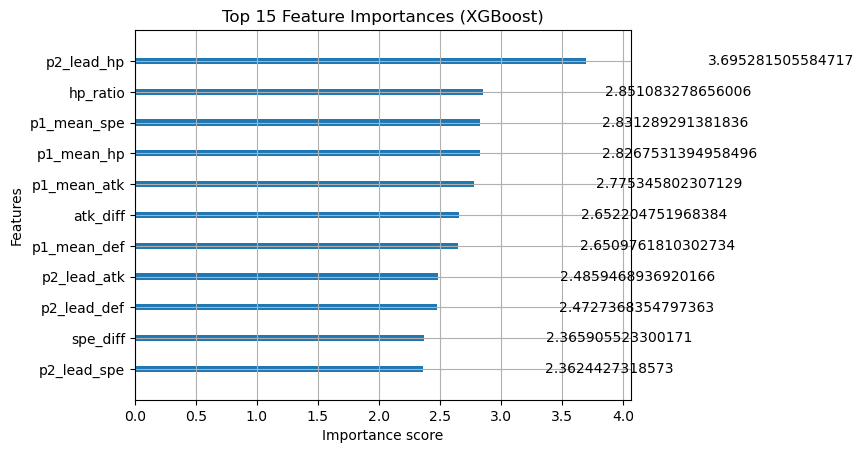

In [ ]:


import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()




In [ ]:

# Convert to a dataframe
import pandas as pd

importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Influential Features:")
print(importance_df.head(10))




Top 10 Most Influential Features:
        Feature  Importance
4    p2_lead_hp    3.695282
8      hp_ratio    2.851083
3   p1_mean_spe    2.831289
0    p1_mean_hp    2.826753
1   p1_mean_atk    2.775346
9      atk_diff    2.652205
2   p1_mean_def    2.650976
5   p2_lead_atk    2.485947
6   p2_lead_def    2.472737
10     spe_diff    2.365906


In [ ]:


import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# --- Global importance plot ---
shap.summary_plot(shap_values, X, plot_type="bar")

# --- Detailed impact plot ---
shap.summary_plot(shap_values, X)


In [ ]:

# model tuning 

from sklearn.model_selection import GridSearchCV
grid_params = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
}
grid = GridSearchCV(XGBClassifier(eval_metric='logloss'), grid_params, cv=3, scoring='f1')
grid.fit(X, y)
print(grid.best_params_)

model = XGBClassifier(scale_pos_weight = len(y[y==0]) / len(y[y==1]))


In [ ]:
# === MODELING WITH K-FOLD CROSS VALIDATION ===

features = [c for c in train_df.columns if c not in ['battle_id', 'player_won']]
X = train_df[features]
y = train_df['player_won']

model = LogisticRegression(
    C=REGULARISATION_STRENGTH,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print(f"{N_FOLDS}-fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


# Train Final Model + Submit

In [232]:
# === FINAL TRAINING & SUBMISSION FILE ===
model.fit(X, y)
X_test = test_df[features]
preds = model.predict(X_test)

submission = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': preds
})

submission.to_csv('submission.csv', index=False)
print("submission.csv created successfully!")
display(submission.head())


submission.csv created successfully!


,battle_id,player_won
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
